# Exploring 311 Calls
## About
311 is a service that New York City residents can use to make non-emergency reports to the city for things like noise complaints, graffiti, potholes, etc. Each complaint that comes into the city is registered, along with additional information like the location, the neighborhood, the agency that responded to the request, etc.

https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

The data at the link gets updated, but the data used for this analysis was a specific snapshot taken and stored in a DB for querying.

## Setting things up

In [2]:
!pip install psycopg2-binary
!pip install reverse_geocoder

     |████████████████████████████████| 3.0 MB 4.2 MB/s 
     |████████████████████████████████| 2.2 MB 5.6 MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=383387f176bc4300ccb6e86397f540609cb9ff26df4cca878c248031242894b7
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder


In [3]:
import pandas as pd
import psycopg2
import datetime
import numpy as np
import reverse_geocoder
import matplotlib.pyplot as plt
save_dir = '/content/drive/MyDrive/Python/ezoic/'

In [4]:
def query_db(query):
	'''
	Runs sql query on 311 database and returns a pandas DataFrame.
	Redshift is a data warehouse based on PostgreSQL, so syntax is mostly the same
	'''
	host = 'interview-ds.ckgnwnm6pw4o.us-east-1.redshift.amazonaws.com'
	port = 5439
	db = 'interview'
	username = 'dsguest'
	password = 'nX9EFYUZ5Yu#0q'
	conn = psycopg2.connect(host=host, port=port, dbname=db, user=username, password=password)
	cur = conn.cursor()
	cur.execute(query)
	rows = cur.fetchall()
	df = pd.DataFrame(rows)
	return df

In [5]:
complaint_p_year = "SELECT COUNT(unique_key) , EXTRACT(YEAR FROM  created_date) as YEAR FROM public.three_one_one GROUP BY YEAR ORDER BY YEAR;"
complaint_by_monthyear = "SELECT COUNT(unique_key), EXTRACT(month FROM created_date) as month, EXTRACT(year from created_date) as year FROM public.three_one_one GROUP BY month, year;"
complaint_type_by_borough = "SELECT COUNT(unique_key) , BOROUGH, COMPLAINT_TYPE FROM public.three_one_one GROUP BY BOROUGH, COMPLAINT_TYPE ORDER BY BOROUGH;"
complaint_count_by_borough = "SELECT COUNT(unique_key) count, BOROUGH FROM public.three_one_one GROUP BY BOROUGH ORDER BY count;"
complaint_type_by_city = "SELECT COUNT(unique_key) , CITY, COMPLAINT_TYPE FROM public.three_one_one GROUP BY CITY, COMPLAINT_TYPE ORDER BY CITY;"
complaint_time_day =  "SELECT COUNT(unique_key) , EXTRACT(HOUR FROM  created_date) as HOUR FROM public.three_one_one GROUP BY HOUR ORDER BY HOUR;"
time_complete = "SELECT COUNT(unique_key) , EXTRACT(EPOCH FROM (closed_date - created_date))/60 AS MINUTES FROM public.three_one_one  WHERE closed_date IS NOT NULL GROUP BY MINUTES ORDER BY MINUTES;"
total_count = "SELECT  COUNT(unique_key) FROM public.three_one_one  ;"
unique_complaint = "SELECT DISTINCT complaint_type FROM public.three_one_one;"
unique_location = 'SELECT DISTINCT location_type FROM public.three_one_one ;'
unique_address = 'SELECT DISTINCT address_type FROM public.three_one_one ;'
unspecified_jan = "SELECT unique_key, created_date, agency, latitude, longitude, location,  extract(month from created_date) as month, borough from public.three_one_one WHERE month=1 AND borough='Unspecified'"
unspecified_geo = "SELECT unique_key, created_date, agency, latitude, longitude, location,  extract(month from created_date) as month, borough from public.three_one_one WHERE latitude IS NOT NULL AND borough='Unspecified'"



## Data Exploration
Understanding the possible values for each field.
Total records: 21,351,116


**Unique Key**

A 7 digit number

**Service Requests**

Thoughts: Repeated for different boroughs and under different complaint types are the categories Noise, Hot Water, and Parking. These are clearly the most common causes for public inconvenience. This could drive the city to look for systemic causes of hot water problems. It would also be interesting to see which complaint types are the most tardy to understand where the city is having the hardest time keeping up with resolving complaints.  

In [23]:
complaint_count = "SELECT COUNT(unique_key) , COMPLAINT_TYPE FROM public.three_one_one GROUP BY COMPLAINT_TYPE;"
df = query_db(complaint_count)
df.columns = ["Service Requests", "Complaint Type"]
df

,Service Requests,Complaint Type
0,302981,ELECTRIC
1,351446,Sewer
2,300457,Sanitation Condition
3,461147,Noise
4,630164,Water System
...,...,...
428,1,Misc. Comments'
429,1,Misc. Comments69075347' or ...
430,1,Misc. Comments> BCC:bl0...
431,1,1430*4963


**Location Type**

171 different values.
The counts drop off by 1/50th in the first ten

In [ ]:
location_count = "SELECT COUNT(unique_key) count, location_type FROM public.three_one_one GROUP BY location_type ORDER BY count DESC;"


In [ ]:
df = query_db(location_count)

In [7]:
df.columns = ["Service Requests", "Location Type"]
df.iloc[0:10]

,Service Requests,Location Type
0,5784609,RESIDENTIAL BUILDING
1,5201731,
2,2770314,Street/Sidewalk
3,2008619,Street
4,1796405,Residential Building/House
5,1429367,Sidewalk
6,211156,Property Address
7,194850,Store/Commercial
8,182805,Club/Bar/Restaurant
9,171005,Senior Address


**Address Type**

All values below. Dropping off by 4 orders of magnitude in six values

In [ ]:
address_count = "SELECT COUNT(unique_key) count, address_type FROM public.three_one_one GROUP BY address_type ORDER BY count DESC;"

In [ ]:
df = query_db(address_count)
df.columns = ["Service Requests", "Address Type"]

In [9]:
df

,Service Requests,Address Type
0,16497783,ADDRESS
1,3120613,INTERSECTION
2,1032616,
3,529024,BLOCKFACE
4,161368,LATLONG
5,9712,PLACENAME


**Complaint Type**

433 unique values

There are unfortunately many errors in the complaint types. Not a high percent, but large in number.

Unlike location type, the counts drop off gradually as you go down the list.


In [ ]:
complaint_count = "SELECT COUNT(unique_key) count, complaint_type FROM public.three_one_one GROUP BY complaint_type ORDER BY count DESC;"

In [10]:
df = query_db(complaint_count)
df.columns = ["Service Requests", "Complaint Type"]

In [11]:
df

,Service Requests,Complaint Type
0,1722501,Noise - Residential
1,1149728,HEAT/HOT WATER
2,939603,Street Condition
3,891730,Street Light Condition
4,887869,HEATING
...,...,...
428,1,./validate_form.php
429,1,g0oii1s4s5)(objectClass=*
430,1,() { _; } >_
431,1,../../WEB-INF/web.xml


**Agency Name**

Agency Name is sometimes a subset of Agency, sometimes a full spelling of a short name


In [16]:
agency_count = "SELECT COUNT(unique_key) count, agency FROM public.three_one_one GROUP BY agency ORDER BY count DESC;"

In [17]:
df = query_db(agency_count)

In [22]:
df.columns = ["Service Requests","Agency"]
df["Service Requests"] = df["Service Requests"].apply(lambda x: "{:,}".format(x))
print(df.iloc[0:14])
print(df.shape)

   Service Requests Agency
0         5,844,547    HPD
1         4,955,501   NYPD
2         2,955,995    DOT
3         1,860,906   DSNY
4         1,682,666    DEP
5         1,166,379    DOB
6           936,862    DPR
7           543,441  DOHMH
8           511,033    DOF
9           245,092    TLC
10          190,653    DCA
11          182,117    DHS
12          113,953    HRA
13           92,567   DFTA
(31, 2)


**Pairing Complaints and Agency**

In [12]:
complaint_by_agency = "SELECT DISTINCT AGENCY, AGENCY_NAME, COMPLAINT_TYPE FROM public.three_one_one ORDER BY AGENCY;"
complaint_by_agency_short = "SELECT DISTINCT AGENCY, COMPLAINT_TYPE FROM public.three_one_one ORDER BY AGENCY;"

In [ ]:
df = query_db(complaint_by_agency)

In [14]:
df.columns = ["Agency","Agency Name" ,"Complaint Type"]
df

,Agency,Agency Name,Complaint Type
0,3-1-1,3-1-1,Noise Survey
1,3-1-1,311 Administrative Supervisor,Sidewalk Condition
2,3-1-1,3-1-1 Call Center,Meals Home Delivery Required
3,3-1-1,3-1-1 Call Center,LinkNYC
4,3-1-1,3-1-1,DOF Property - State Rebate
...,...,...,...
2882,TLC,Correspondence - Taxi and Limousine Commission,Taxi Complaint
2883,TLC,Taxi and Limousine Commission,Green Taxi Report
2884,TLC,Taxi and Limousine Commission,FHV Licensee Complaint
2885,TLC,Taxi and Limousine Commission,Dispatched Taxi Compliment


**Complaint Type per Agency**

To understand: the relationship be complaint type and agency

In [15]:
df = query_db(complaint_by_agency_short)
df.columns = ["Agency" ,"Complaint Type"]
df

,Agency,Complaint Type
0,3-1-1,Homeless Person Assistance
1,3-1-1,DOF Property - City Rebate
2,3-1-1,Noise - Helicopter
3,3-1-1,Sidewalk Condition
4,3-1-1,Benefit Card Replacement
...,...,...
484,TLC,Green Taxi Report
485,TLC,Dispatched Taxi Complaint
486,TLC,Taxi Report
487,TLC,Dispatched Taxi Compliment


Sample taken from exploring the above in excel

**Agency** ..**Complaint Type**

DOB .......Single Occupancy Bathroom

3-1-2001 Sidewalk Condition

DOT .......Sidewalk Condition

NYPD .....Sidewalk Condition






**Thoughts**: this shows us that a complaint type is not restricted to one type of agency

## Data Analysis

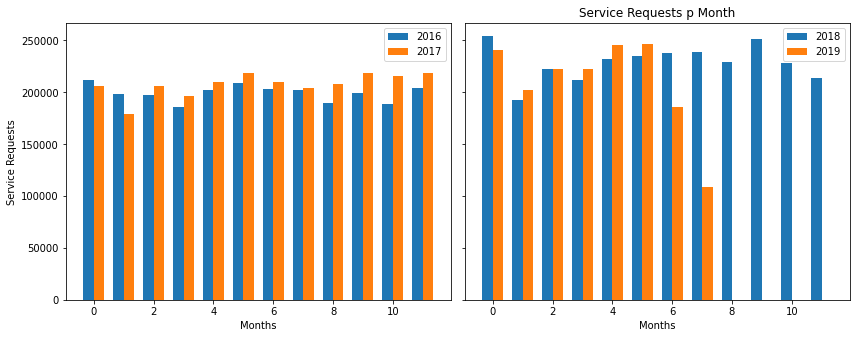

In [ ]:
df = query_db(complaint_by_monthyear)
def pull_months(df, year):
  data =  df[df['year']==year]['Service Requests'].to_numpy()
  if data.shape[0]<12:
    tmp = list(data)
    while (len(tmp) < 12):
      tmp.append(0)
    data = np.array(tmp)
  return data
df.columns = ['Service Requests','month', 'year']
df.sort_values(['month', 'year'], inplace=True)
df.iloc[df.shape[0]-1]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] 
width = 0.35
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = [12, 4.8])
x = np.arange(len(months))

ax[0].bar(x - width/2, pull_months(df, 2016), width, label='2016')
ax[0].bar(x + width/2, pull_months(df, 2017), width, label='2017')
ax[0].set_ylabel('Service Requests')
ax[0].set_xlabel('Months')
ax[0].legend()
ax[1].bar(x - width/2, pull_months(df, 2018), width, label='2018')
ax[1].bar(x + width/2, pull_months(df, 2019), width, label='2019')
ax[1].set_xlabel('Months')
ax[1].legend()
plt.title("Service Requests p Month")
fig.tight_layout()
plt.show()

In [ ]:
##2019 NYC population estimates https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/PST045219
population_by_borough = {'BRONX':1418207, 'BROOKLYN':2559903, 'MANHATTAN':1628706, 'QUEENS':2253858, "STATEN ISLAND":476143}

In [ ]:
res = query_db(complaint_by_agency_short)
res.to_csv(save_dir+'complaint_by_agency_short.csv')

### Service Requests per Year

In [ ]:
df = query_db(complaint_p_year)

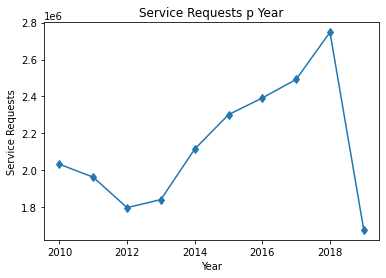

In [ ]:
df.columns = ['Service Requests', 'Year']
plt.plot(df['Year'],df['Service Requests'], marker='d')
plt.title("Service Requests p Year")
plt.xlabel("Year")
_ = plt.ylabel("Service Requests")
plt.savefig(save_dir + 'Service_Requests_p_Year')


There must have been a significant event in the year 2019 to account for such a drop. Perhaps the data isn’t collected throughout the year. Considering most requests come from noise complaints, parking violations, and hot water outages, it is unlikely the sources of these problems could be systematically solved overnight. 

In [ ]:
res = query_db("SELECT created_date, EXTRACT(YEAR FROM  created_date) as YEAR FROM public.three_one_one WHERE YEAR =2019 ORDER BY created_date DESC")

In [ ]:
date_last_complaint = res.iloc[0, 0].date()
print("last complaint was on ", date_last_complaint)

last complaint was on  2019-08-20


The oldest complaint was on August 20 2019; 2/3rd of the way through the year. If we scale the last data point linearly we get.

expected scale ~ 1.33
scale: 1.367123287671233
service requests in db: 1,675,384
scaled service requests : 2,290,456


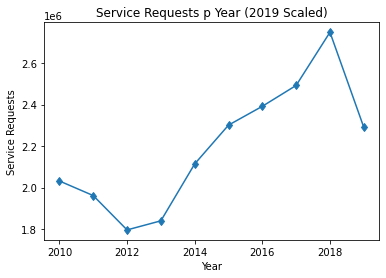

In [ ]:
df_scaled = df.copy()
date_diff = date_last_complaint - datetime.date(2019, 1, 1) 
scale = 1 + (1-date_diff.days/365)
print("expected scale ~ 1.33\nscale:", scale)
requests_2019 = df_scaled[df_scaled["Year"] == 2019]["Service Requests"].iloc[0]
print("service requests in db:", "{:,}".format(requests_2019))
df_scaled["Service Requests"].loc[df_scaled['Year']==2019] = int(requests_2019*scale)
scaled_requests = df_scaled[df_scaled["Year"] == 2019]["Service Requests"].iloc[0]
print("scaled service requests :" , "{:,}".format(scaled_requests))

plt.plot(df_scaled['Year'],df_scaled['Service Requests'], marker='d')
plt.title("Service Requests p Year (2019 Scaled)")
plt.xlabel("Year")
_ = plt.ylabel("Service Requests")
plt.savefig(save_dir + 'Service_Requests_p_Year_scaled')

This doesn't look good. It doesn't continue the trend. It drops below 2017 levels. We applied a simplistic linear function to the 2019 data. What is the trend in requests per month per year? Was linear scaling reasonable? Do significantly more tests happen in December vs July?

In [ ]:
df_m = query_db(complaint_by_monthyear)

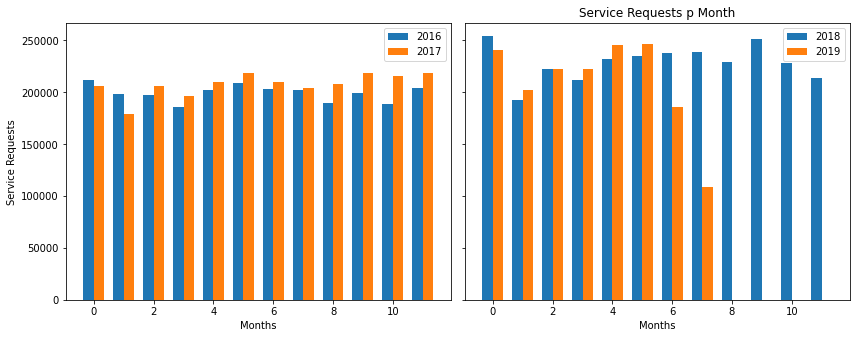

In [ ]:
def pull_months(df, year):
  data =  df[df['year']==year]['Service Requests'].to_numpy()
  if data.shape[0]<12:
    tmp = list(data)
    while (len(tmp) < 12):
      tmp.append(0)
    data = np.array(tmp)
  return data
df_m.columns = ['Service Requests','month', 'year']
df_m.sort_values(['month', 'year'], inplace=True)
df_m.iloc[df_m.shape[0]-1]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] 
width = 0.35
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize = [12, 4.8])
x = np.arange(len(months))

ax[0].bar(x - width/2, pull_months(df_m, 2016), width, label='2016')
ax[0].bar(x + width/2, pull_months(df_m, 2017), width, label='2017')
ax[0].set_ylabel('Service Requests')
ax[0].set_xlabel('Months')
ax[0].legend()
ax[1].bar(x - width/2, pull_months(df_m, 2018), width, label='2018')
ax[1].bar(x + width/2, pull_months(df_m, 2019), width, label='2019')
ax[1].set_xlabel('Months')
ax[1].legend()
plt.title("Service Requests p Month")
fig.tight_layout()
plt.savefig(save_dir + 'Service_Requests_by_MonthYear')

Worth while doing to see if linear scaling was a good choice, but I think it was. Something weird happens in June and July of 2019 with the service requests that doesn't happen in any other time in [2016-2018], but that is likely just based on something about how the data was downloaded/aggregated. If it was truly important to figure out, perhaps one could look into how the data gets aggregated into a centra database and if any particular complaint type started falling off unexpectedly or if they all fell off equally together.
Since the first 5 months of 2019 match pretty well with 2018, and only months [8-12] were scaled up, the difference in months June and July would be the reason for the drop in the chart even after scaling. 

### Service Requests per Borough
first plotting the values raw from the DB and then exploring how to clean them up

In [ ]:
def plot_p_borough(df):
  indices = list(range(df.shape[0]))
  plt.bar(indices,df['Service Requests'])
  df.at[0,'Boroughs']='unknown'
  plt.xticks(ticks = indices,labels=df['Boroughs'], rotation=35)
  plt.title('Service Requests p Borough')
  plt.xlabel("Boroughs")
  plt.ylabel('Service Requests')
  plt.ylim(top=pow(10,6)*7)
  for index,data in enumerate(df['Service Requests']):
      plt.text(x=index-0.5 , y =data+pow(10,5) , s="{:,}".format(data) , fontdict=dict(fontsize=10))
  plt.tight_layout()

  plt.savefig(save_dir + 'Service_Requests_p_Borough')  

In [ ]:
df = query_db(complaint_count_by_borough)

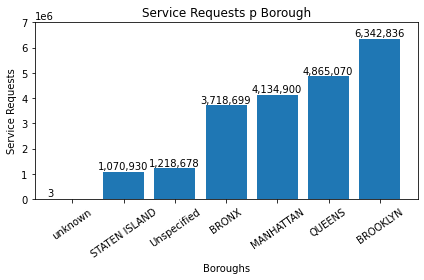

In [ ]:
df.rename(columns={0:'Service Requests', 1:'Boroughs'}, inplace=True) 
plot_p_borough(df)

There are two values in the Borough field that represent absent data: NULL, Unspecified
Together these are substantial and could significantly alter the stats that you could derive for any borough.
**Question**: Can we 'fix' the unspecified Borough values in anyway

In [ ]:
df_j = query_db(unspecified_geo)

In [ ]:
ct_unspecified = df[df['Boroughs']=="Unspecified"]['Service Requests'].iloc[0]
df_j.columns = ['unique_key', 'created_date', 'agency', 'latitude', 'longitude', 'location', 'month', 'borough']
ct_no_geo = ct_unspecified - df_j.shape[0]
ct_geo = df_j.shape[0]
perc = round(100*ct_geo/(ct_unspecified),1)
print("percent of unspecified boroughs with lat and long: %", perc)

percent of unspecified boroughs with lat and long: % 68.2


Thats a pretty high number of values that can be corrected with a simple lat long lookup

In [ ]:
def str_to_tuple_floats(val):
  if not val:
    return np.nan
  if type(val)==str:
    val = val.replace("(", "")
    val = val.replace(")", "")
    values = val.split(",")
    return [float(x) for x in values]
  elif type(val)==list or type(val)==float:
    return val
  else:
    raise ValueError("incorrect input type" + str(type(val)))
df_j['location'] = df_j['location'].apply(str_to_tuple_floats)
df_j_nan = df_j.assign(borough=np.nan)


In [ ]:
print("number of geo locations to fix", "{:,}".format(df_j_nan.shape[0]))

number of geo locations to fix 831,016


The boroughs of Queens and the Bronx are also Queens County and Bronx County. The other three counties are named differently from their boroughs: Manhattan is New York County, Brooklyn is Kings County, and Staten Island is Richmond County

In [ ]:
borough_map = {'richmond county':'staten island', 'new york county': 'manhattan', 'kings county': 'brooklyn', 'bronx county':'bronx', 'bronx':'bronx', 'queens county':'queens'}
borough_map.update({"bergen county": "NJ", "nassau county": "LI", "hudson county": "NJ", "westchester county":"NY - outside NYC", "middlesex county": "NJ"})
def dic_to_borough(dic_list):
  '''input list of an ordered dict from reverse_geocoder'''
  dic = dic_list[0]
  bor = dic['admin2']
  if bor=='' and dic['name']=='New York City' and dic['admin1']=='New York':
    return 'manhattan'
  if bor.lower() not in borough_map.keys():
    print(bor)
    return 'unknown'
  return borough_map[bor.lower()].upper() 
def geo_to_borough(geo):
  dic_list = reverse_geocoder.search(geo)
  return dic_to_borough(dic_list)


The reverse_geocoder is VERY slow so we will not fix any large percentage of the values

In [ ]:
last = 49
series = df_j_nan.loc[0:last, 'location'].apply(geo_to_borough)
df_fix_b = series.to_frame('borough')

In [ ]:
print("Before update\nnumber of rows with a borough", df_j_nan[pd.notna(df_j_nan['borough'])].shape[0])
df_j_nan.update(df_fix_b)
print("\nAfter update\nnumber of rows with a borough", df_j_nan[pd.notna(df_j_nan['borough'])].shape[0])
print("number of rows without a borough", "{:,}".format(df_j_nan[pd.isna(df_j_nan['borough'])].shape[0]))


Before update
number of rows with a borough 50

After update
number of rows with a borough 50
number of rows without a borough 830,966


Now that we have the structure in place, all we would have to do is update df from Service Requests p borough with the new values.
1. count the number of boroughs found (expected to be 831,016)
2. subtract that number from the Unspecified count
3. add the unknown to the unspecified and delete the unknown record since its a synonym
4. perform a groupby then count on df_j_nan to get the count for each borough
5. add the counts for these boroughs to the counts in df
6. remake the graph and the Unspecified values will be less than half their current size

This will not be done as the reverse_geocoder is very slow and I'm not getting paid so I'm not motivated to find a solution to that. 
Solutions could include brute force or modifying the loop to perform async calls - depends on how reverse_geocoder works under the hood, but I could believe that IO wait time is a bottlekneck here. 

### per capita
**Question**: What borough has the most requests per capita?
Normalize the column chart of service request counts based on populations in the respective boroughs

In [ ]:
def clean_borough_count(df):
  dfn = df.copy()
  null_index = dfn[dfn['Boroughs']==''].index[0]
  dfn.at[null_index,'Service Requests']
  unspecified_index = dfn[dfn['Boroughs']=='Unspecified'].index[0]
  dfn.at[unspecified_index,'Service Requests'] += dfn.at[null_index,'Service Requests']
  return dfn.drop(index=null_index)

In [ ]:
def per_capita_borough_count(dfo, population_by_borough):
  print("Warning: have to drop unspecified data")
  df = dfo.drop(index = dfo[dfo['Boroughs']=='Unspecified'].index[0])
  df = df.astype({'Service Requests':float})
  for name in population_by_borough.keys():
    population = population_by_borough[name]
    service_requests = df.at[df[df['Boroughs']==name].index[0], 'Service Requests']
    df.at[df[df['Boroughs']==name].index[0], 'Service Requests'] /=population
  return df

In [ ]:
def plot_p_borough_p_capita(df):
  indices = list(range(df.shape[0]))
  plt.bar(indices,df['Service Requests'])
  plt.xticks(ticks = indices,labels=df['Boroughs'], rotation=35)
  plt.title('Service Requests p capita p Borough')
  plt.xlabel("Boroughs")
  plt.ylabel('Service Requests per capita')
  plt.ylim(top=3, bottom=2)
  for index,data in enumerate(df['Service Requests']):
      plt.text(x=index-0.2 , y =data+0.05 , s=str(round(data,2)) , fontdict=dict(fontsize=10))
  plt.tight_layout()

  plt.savefig(save_dir + 'Service_Requests_p_capita_p_Borough') 

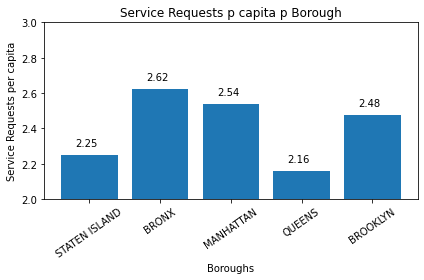

In [ ]:
df = query_db(complaint_count_by_borough)
df.rename(columns={0:'Service Requests', 1:'Boroughs'}, inplace=True) 
dfn = clean_borough_count(df)
dfn = per_capita_borough_count(dfn, population_by_borough)
plot_p_borough_p_capita(dfn)

I expected the service requests per capita to be very different for the different cities. In theory, Manhattan gets more visitors relative to residents so one could believe it would have a higher ratio. These are all between 2 - 3. Perhaps the one million+ unspecified service requests would add distortion to this per capita chart if they could be assigned properly. 

### Time to Complete

**Question** What is the distribution of time it takes for a ticket to be resolved (closed-open)?

In [ ]:
df = query_db(time_complete)

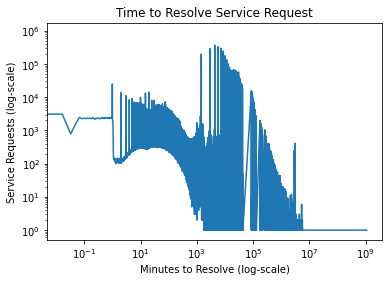

In [ ]:
df.rename(columns={0:'Service Requests', 1:'Minutes'}, inplace=True) 
plt.plot(df['Minutes'], df['Service Requests'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Minutes to Resolve (log-scale)')
plt.ylabel('Service Requests (log-scale)')
plt.title("Time to Resolve Service Request")
plt.savefig(save_dir + 'time_to_resolve')

**Thoughts**: This is definitely the weirdest graph I have made. The distribution is enormous (table of conversions below). Many tickets seem to be completed in less than 10 minutes which makes me think the tickets may be duplicates or errors. The highest numbers are around pow(10,4) which makes sense that it would take days for non-emergency requests to be resolved.

It would be interesting to see this graph binned into non-linear categories: day, week, month, year, decade

**Minutes	Time**
pow(10,3)	16.6 hours
pow(10,4)	7 days
pow(10,5)	2.3 months
pow(10,6)	1.9 years

**Open Question**
Average time taken per complaint type per agency? 
column chart with std error bars

### Rank Agency Response Times

**Goal**: Rank the agencies based on how late they are to fulfilling their requests

Presumably, the time worked on the complaint is closed_date – created_date.

[eq1]	closed_date – created_date = total_time_complaint
how long the agency has to respond based on SLAs

[eq2]	due_date – created_date = allowed_time

If tardiness is negative it will be set to zero since completion before the deadline is simply considered acceptable whereas completion after the deadline will be scored negatively linearly as time pass normalized by allowed_time. If 5 minutes is given and the agency is one minute late it will weight equally as if 5 hours is given and the agency is 1 hour late – 20% late in both cases.

[eq3]	total_time_complaint – allowed_time = tardiness

[eq4]	(total_time_complaint – allowed_time)/allowed_time  = tardiness_normalized